In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/NN_Competition_Project/terrain-identification')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from helper_functions import *
from lstm_models import LSTM_2
from preprocess import *
from templates import *
import warnings
import numpy as np
import sys

warnings.filterwarnings("ignore")

#### Get the data in Time Series Format

In [ ]:
train_X, train_y = get_ts_format(X_files, y_files, WINDOW_SIZE, STEP_SIZE)
val_X, val_y = get_ts_format(val_X_files, val_y_files, WINDOW_SIZE, STEP_SIZE)
test_X, test_y = get_ts_format(test_X_files, test_y_files, WINDOW_SIZE, STEP_SIZE)

In [ ]:
# print(train_X.shape, train_y.shape)
# print(val_X.shape, val_y.shape)
# print(test_X.shape, test_y.shape)

#### Save the Data in array format for future use

In [ ]:
np.save('sampled_data/train_X.npy', train_X)
np.save('sampled_data/train_y.npy', train_y)
np.save('sampled_data/val_X.npy', val_X)
np.save('sampled_data/val_y.npy', val_y)
np.save('sampled_data/test_X.npy', test_X)
np.save('sampled_data/test_y.npy', test_y)

#### Load the Saved Data

In [ ]:
# Loading the saved data
path = '/content/drive/MyDrive/NN_Competition_Project/terrain-identification/sampled_data/'
train_X = np.load(path + '/train_X.npy')
train_y = np.load(path + '/train_y.npy')
val_X = np.load(path + '/val_X.npy')
val_y = np.load(path + 'val_y.npy')
test_X = np.load(path + '/test_X.npy')
test_y = np.load(path + '/test_y.npy')

#### Assign weights to classes for imbalance

In [ ]:
# Get training label weights
label_weights = assign_weights(train_X, train_y)
print(label_weights)

{0: 0.3258715475333822, 1: 5.860711164745537, 2: 4.427916810764926, 3: 1.8697229376310969}


#### OneHotEncode the Labels

In [ ]:
# Perform one-hot encoding on all labels
train_y_encoded = encode_labels(train_y)
val_y_encoded = encode_labels(val_y)
test_y_encoded = encode_labels(test_y)
print(train_y_encoded.shape, val_y_encoded.shape, test_y_encoded.shape)

(1126710, 4) (122696, 4) (91260, 4)


#### Define LSTM Model

In [ ]:
model = LSTM_2(train_X, train_y_encoded)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              138240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 171,652
Trainable params: 171,652
Non-trainable params: 0
_________________________________________________________________


#### Fit LSTM Model

In [ ]:
history = model.fit(train_X, train_y_encoded, epochs = 10, batch_size = 32,
                   validation_data = (val_X, val_y_encoded), class_weight = label_weights,
                   verbose = 1, shuffle = True)

Epoch 1/10
35210/35210 [==============================] - 289s 8ms/step - loss: 0.1891 - acc: 0.8909 - val_loss: 1.2283 - val_acc: 0.6238
Epoch 2/10
35210/35210 [==============================] - 277s 8ms/step - loss: 0.0932 - acc: 0.9425 - val_loss: 1.9452 - val_acc: 0.6181
Epoch 3/10
35210/35210 [==============================] - 286s 8ms/step - loss: 0.0670 - acc: 0.9566 - val_loss: 1.8930 - val_acc: 0.6156
Epoch 4/10
35210/35210 [==============================] - 286s 8ms/step - loss: 0.0532 - acc: 0.9656 - val_loss: 2.6581 - val_acc: 0.6246
Epoch 5/10
35210/35210 [==============================] - 288s 8ms/step - loss: 0.0443 - acc: 0.9714 - val_loss: 2.8014 - val_acc: 0.6284
Epoch 6/10
35210/35210 [==============================] - 285s 8ms/step - loss: 0.0388 - acc: 0.9752 - val_loss: 3.0925 - val_acc: 0.6490
Epoch 7/10
35210/35210 [==============================] - 277s 8ms/step - loss: 0.0345 - acc: 0.9782 - val_loss: 2.9769 - val_acc: 0.6584
Epoch 8/10
35210/35210 [==========

#### Save the Model

In [ ]:
# saving model
model_yaml = model.to_json()
with open('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/model/model2.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)
model.save_weights('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/model/model2.h5')
print('Saved model to disk.')

Saved model to disk.


#### Evaluate the Performance on Test Dataset

In [ ]:
model.evaluate(test_X, test_y_encoded)

2852/2852 [==============================] - 15s 5ms/step - loss: 0.2363 - acc: 0.9452


[0.23632611334323883, 0.9452114701271057]

#### Predictions and Classification Report

In [ ]:
predicted_data = model.predict(test_X, batch_size = 64, verbose = 1)
y_test_bool = np.argmax(predicted_data, axis = 1)
print(classification_report(test_y, y_test_bool))

1426/1426 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     65623
           1       0.85      0.99      0.91      2892
           2       0.92      0.99      0.96      3745
           3       0.91      0.86      0.89     19000

    accuracy                           0.95     91260
   macro avg       0.91      0.95      0.93     91260
weighted avg       0.95      0.95      0.94     91260



#### Get the Mode of Predicted labels

In [ ]:
y_actual = calculate_mode(y_test_bool)

In [ ]:
N_STEPS = 30
STEP_INCREMENT = 1
BATCH_SIZE = 64
L = len(test_files)

for idx in range(L):
    file = pd.read_csv(test_files[idx], names=X_HEADER)

    dataframe = normalize_data(file, list(file.columns.values))
  
    X_test = get_ts_testdata(dataframe, N_STEPS, STEP_INCREMENT)

    y_frame = pd.read_csv(y_files[idx], names=Y_HEADER)
    
    reshape_y = y_frame.shape[0] * 4 - dataframe.shape[0] + N_STEPS
   
    reshape_dataframe = pd.DataFrame(dataframe.iloc[-reshape_y:])

    dataframe = dataframe.append(reshape_dataframe)
    
    y_test = model.predict(X_test, batch_size = BATCH_SIZE)
   
    y_test = np.argmax(y_test, axis = 1)
   
    y_true = np.ravel(calculate_mode(y_test))
   
    y_true = pd.Series(y_true)
    y_true.to_csv("/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions/" + prediction_files[idx])

#### Plot the Grpahs of Accuracy and Losses

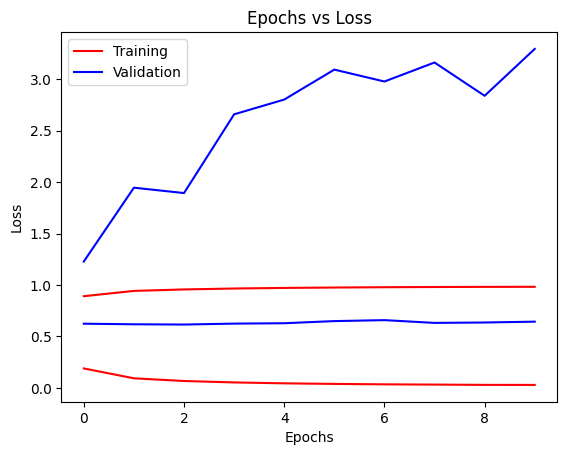

In [ ]:
plot_metrics(history)

#### Save the Final Preditions

In [ ]:
subject_009_01__y = pd.read_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions/subject_009_01__y.csv')
subject_009_01__y.iloc[:, 1].to_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions_single_column/subject_009_01__y.csv', index=False)

In [ ]:
subject_009_01__y = pd.read_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions/subject_010_01__y.csv')
subject_009_01__y.iloc[:, 1].to_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions_single_column/subject_010_01__y.csv', index=False)

In [ ]:
subject_009_01__y = pd.read_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions/subject_011_01__y.csv')
subject_009_01__y.iloc[:, 1].to_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions_single_column/subject_011_01__y.csv', index=False)

In [ ]:
subject_009_01__y = pd.read_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions/subject_012_01__y.csv')
subject_009_01__y.iloc[:, 1].to_csv('/content/drive/MyDrive/NN_Competition_Project/terrain-identification/C3.2_predictions_single_column/subject_012_01__y.csv', index=False)